# Metrics

下ごしらえ

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interact

今回は肺がんの予測をデータセットとして使います。

In [2]:
from sklearn.datasets import load_breast_cancer
breast=load_breast_cancer()
data=breast.data
target=breast.target

datasetの中身

In [3]:
breast.keys()

dict_keys(['target', 'data', 'feature_names', 'target_names', 'DESCR'])

In [4]:
print(data.shape)
print(target.shape)

(569, 30)
(569,)


In [5]:
for i,j in enumerate(breast.target_names):
    print("{}: {}".format(j,sum(target==i)))

malignant: 212
benign: 357


特徴量（検査値）

In [6]:
pd.DataFrame(data,columns=breast.feature_names).head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


適当にモデルを作っときます。

In [7]:
from sklearn import cross_validation as cv
data_train,data_test,target_train,target_test=cv.train_test_split(
    data,target,train_size=0.75)

In [8]:
from sklearn.ensemble import RandomForestClassifier as RFC
clf=RFC()
clf.fit(data_train,target_train)
predict=clf.predict(data_test)
predict_proba=clf.predict_proba(data_test)
# precision-recall curveにはスカラー値でのスコアリングが必要

# 今回のお題

In [9]:
from sklearn import metrics

簡単なところから

In [10]:
# 正答率
metrics.accuracy_score(predict,target_test)

0.965034965034965

In [11]:
# 混同行列
print(metrics.confusion_matrix(predict,target_test))

[[52  3]
 [ 2 86]]


縦軸がpredict, 横軸がtarget_test(左下がFN,右上がFP)

## precision-recall関係
> [神嶌先生の解説参照](http://ibisforest.org/index.php?F%E5%80%A4)

予測全体のPrecisionやRecall値 

In [12]:
# Precision、RecallとF値とsupport(正解ラベルのデータの数)
print(metrics.classification_report(
        predict,target_test,target_names=breast.target_names))

             precision    recall  f1-score   support

  malignant       0.96      0.95      0.95        55
     benign       0.97      0.98      0.97        88

avg / total       0.97      0.97      0.96       143



In [13]:
#Precision,Recall値を再利用したい場合はこちらで抽出する
precision, recall, fscore, support=metrics.precision_recall_fscore_support(
    predict,target_test)
print(precision,recall,fscore,support)

[ 0.96296296  0.96629213] [ 0.94545455  0.97727273] [ 0.95412844  0.97175141] [55 88]


Precision-Recall Curve

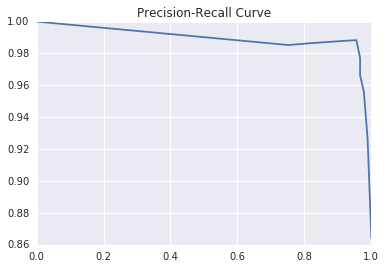

In [14]:
# precision-recall curve
precision,recall,thresholds=metrics.precision_recall_curve(target_test,predict_proba[:,1])
plt.plot(recall,precision) # recallが先なのを注意
plt.title("Precision-Recall Curve")

In [15]:
# AUC算出
metrics.auc(recall,precision) # こちらもrecallが先

0.98935439073855747

precision_recall_curve関数の返り値の中身

In [16]:
pd.DataFrame(np.c_[precision,recall],columns=["precision","recall"]).T

,0,1,2,3,4,5,6,7,8,9
precision,0.864078,0.926316,0.956044,0.966292,0.977273,0.988372,0.987805,0.986301,0.985294,1.0
recall,1.000000,0.988764,0.977528,0.966292,0.966292,0.955056,0.910112,0.808989,0.752809,0.0


recallが閾値以下になった時のprecisionのカットオフにするとかなら

In [17]:
for i,j in enumerate(recall):
    if j<0.8 and i==0:print("error");break
    elif j<0.8:
        print("criteria= {0:.3}".format(precision[i-1]))
        break

criteria= 0.986


# みんな大好きROC curve

ROC curveも関数が用意されています

In [18]:
fp_ratio, tp_ratio, thresholds = metrics.roc_curve(
    target_test,predict_proba[:,1])

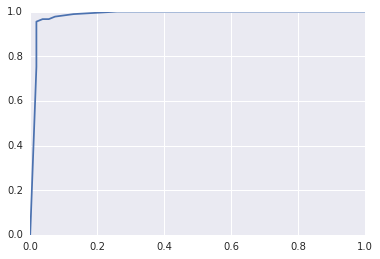

In [19]:
plt.plot(fp_ratio,tp_ratio)

In [20]:
metrics.auc(fp_ratio,tp_ratio)

0.98491468997086973

ROCカーブのAUCは専用の関数があります

In [21]:
metrics.roc_auc_score(target_test,predict_proba[:,1])

0.98491468997086973

あとで使うので、この入出力の形式を覚えておいてください

## おまけ

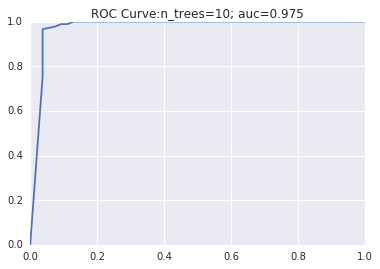

In [22]:
@interact(log_of_n_tree=(0,3,0.1))
def roc(log_of_n_tree=1):
    rslt=RFC(n_estimators=int(10**log_of_n_tree),n_jobs=-1).fit(data_train,target_train).predict_proba(data_test)
    fp_ratio, tp_ratio, thresholds = metrics.roc_curve(target_test,rslt[:,1])
    auc=metrics.roc_auc_score(target_test,rslt[:,1])
    plt.plot(fp_ratio,tp_ratio)
    plt.title("ROC Curve:n_trees={0}; auc={1:.3}".format(int(10**log_of_n_tree),auc))

# スコアリング関数

In [23]:
from sklearn import cross_validation as cv

これで出てくる、scoringの話です

cross validationで使えるスコアリング方法はmetrics.scorer.SCORERSで定義されています

In [24]:
print(list(metrics.scorer.SCORERS.keys()))

['accuracy', 'precision', 'f1_macro', 'recall_macro', 'recall', 'recall_micro', 'f1_weighted', 'recall_samples', 'f1', 'precision_weighted', 'average_precision', 'roc_auc', 'f1_samples', 'median_absolute_error', 'mean_squared_error', 'precision_macro', 'mean_absolute_error', 'adjusted_rand_score', 'precision_samples', 'precision_micro', 'recall_weighted', 'r2', 'log_loss', 'f1_micro']


- 用意されているSCORER以外にもスコアリング関数を定義することが可能です。
- 下記形式で予測結果に対してスカラー量を算出できる関数を作成すれば、make_scorerでSCORERとして使えます。
> score_func(target, predict_proba)


In [25]:
custom_scorer=metrics.scorer.make_scorer(metrics.roc_auc_score)

こんな感じ

In [26]:
cv_method=cv.StratifiedKFold(target_train,shuffle=True,n_folds=5)
cv.cross_val_score(clf,data_train,target_train,cv=cv_method,scoring=custom_scorer)

array([ 0.96585648,  0.94733796,  0.90625   ,  0.97169811,  0.93274498])

- 実際には、scoring="roc_auc"で動作するSCORERはほぼ同じ方法で実装されています

In [27]:
metrics.scorer.SCORERS["roc_auc"]

make_scorer(roc_auc_score, needs_threshold=True)